
# Duck Beach TWL–Forced Equilibrium Shoreline Model

This script implements the improved equilibrium shoreline model for Duck Beach, NC,
forced by wave and total water level (TWL).


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

## 1. Model parameters and constants

In [ ]:
# Paths
PROJECT_ROOT = Path(r"C:\Users\aadhau\OneDrive - University of Florida\1_UF_Coursework\Quant\Project\SRM\Shoreline_Response_Model")
DATA_DIR = PROJECT_ROOT / "data"

WAVE_FILE = DATA_DIR / "Duck_NS_HS.csv"
TWL_FILE = DATA_DIR / "Duck_NS_TWL.csv"
ADJ_SHORE_FILE = DATA_DIR / "duck_observed_shoreline.csv"

# Dean-profile 
A_DEAN = 0.12          # m^(1/3)
BREAKER_INDEX = 0.78
BERM_HEIGHT = 1.5      # m
ALPHA_H = 1.28
Z_CRIT = 0.5           # m
C_EQ = 1.0

# TWL component percentages (%)
MSL_P = 3.27
SE_P = 1.45
TIDES_P = 37.98
SA_P = 1.98
SS_P = 3.31
R2_P = 52.00
TOTAL_P = MSL_P + SE_P + TIDES_P + SA_P + SS_P + R2_P

# Morphologically active fraction 
MORPH_FRAC = (TIDES_P + SS_P + R2_P) / TOTAL_P

# Shoreline response rates [1/day]
K_E = 0.10   # erosion
K_A = 0.03   # accretion

print("Data directory:", DATA_DIR)

Data directory: C:\Users\aadhau\OneDrive - University of Florida\1_UF_Coursework\Quant\Project\SRM\Shoreline_Response_Model\data


## 2. Data loading 

Loading: 
- Shoreline data (Normalized), and
- Offshore forcing (significant wave height `Hs` and total water level `TWL`).
We merge Hs and TWL on time and then clip to the shoreline record
with a small buffer. We also plot:



In [8]:
# Load shoreline (detrended/adjusted)
shore = pd.read_csv(ADJ_SHORE_FILE)
shore["date"] = pd.to_datetime(shore["date"]).dt.tz_localize(None)
shore = shore.sort_values("date").reset_index(drop=True)
shore["y_detr"] = shore["distance"]  # use adjusted distance directly

# Load wave data (Hs)
waves = pd.read_csv(WAVE_FILE)
waves["time"] = pd.to_datetime(waves["time"]).dt.tz_localize(None)
waves = waves.sort_values("time").reset_index(drop=True)
waves = waves.rename(columns={"swan_HS": "Hs"})[["time", "Hs"]]

# Load TWL data
tide = pd.read_csv(TWL_FILE)
tide["time"] = pd.to_datetime(tide["time"]).dt.tz_localize(None)
tide = tide.sort_values("time").reset_index(drop=True)
tide = tide[["time", "TWL"]]


## 3. Merging and forcing plot

Merge Hs and TWL on time and then clip to the shoreline record

> Duck Beach — Forcing Time Series

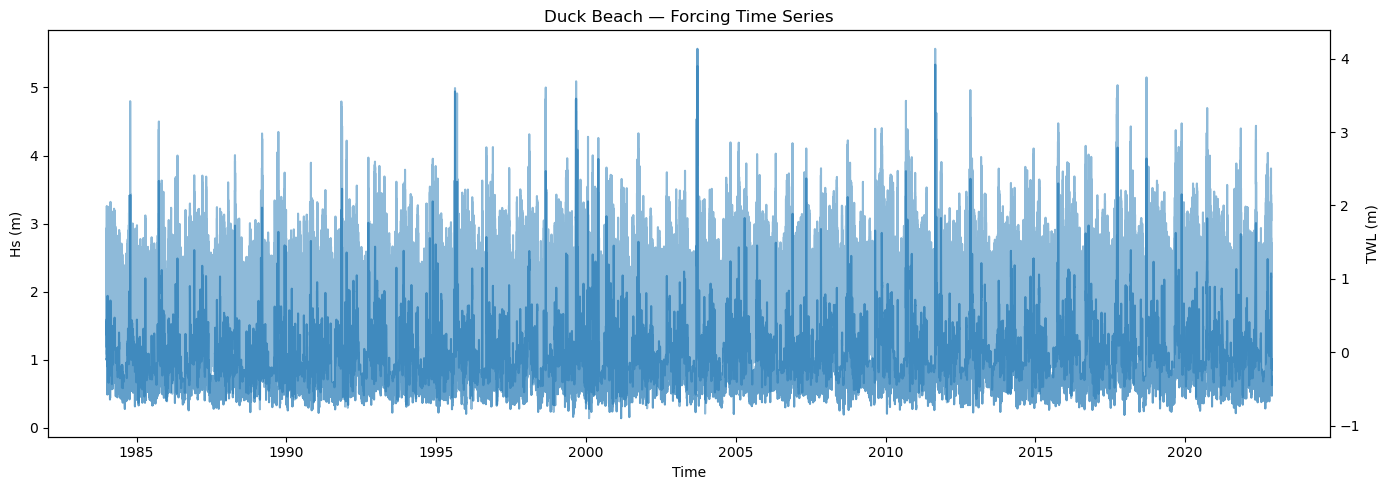

In [9]:
forcing = pd.merge_asof(
    waves.sort_values("time"),
    tide.sort_values("time"),
    on="time",
    direction="nearest"
)


t_shore_min = shore['date'].min()
t_shore_max = shore['date'].max()


buffer_days = 5
t_min = t_shore_min - pd.Timedelta(days=buffer_days)
t_max = t_shore_max + pd.Timedelta(days=buffer_days)

forcing_model = forcing[(forcing['time'] >= t_min) & (forcing['time'] <= t_max)].reset_index(drop=True)


# Plot: Duck Beach — Forcing Time Series

fig, ax1 = plt.subplots(figsize=(14, 5))

ax1.plot(forcing_model['time'], forcing_model['Hs'], label="Hs (m)", alpha=0.7)
ax1.set_xlabel("Time")
ax1.set_ylabel("Hs (m)")

ax2 = ax1.twinx()
ax2.plot(forcing_model['time'], forcing_model['TWL'], label="TWL (m)", alpha=0.5)
ax2.set_ylabel("TWL (m)")

ax1.set_title("Duck Beach — Forcing Time Series")
fig.tight_layout()
plt.show()

## 4. Dean-profile-based equilibrium forcing

Compute the surf-zone width and the equilibrium shoreline change Δy_eq
using a Dean profile and TWL-excess above a critical level:



In [10]:
forcing_eq = forcing_model.copy()


forcing_eq["Hb"] = forcing_eq["Hs"]
forcing_eq["hb"] = forcing_eq["Hb"] / BREAKER_INDEX

# Active surf-zone width from Dean profile
forcing_eq["W_star"] = (forcing_eq["hb"] / A_DEAN) ** 1.5

# TWL exceedance above critical level, scaled by morph. fraction
forcing_eq["TWL_excess"] = np.maximum(forcing_eq["TWL"] - Z_CRIT, 0.0)
forcing_eq["TWL_excess"] *= MORPH_FRAC

# Equilibrium shoreline change Δy_eq
denom = BERM_HEIGHT + ALPHA_H * forcing_eq["Hb"]
forcing_eq["dy_eq"] = -C_EQ * forcing_eq["W_star"] * (forcing_eq["TWL_excess"] / denom)




## 5. Shoreline model: asymmetric linear relaxation

We solve the shoreline evolution equation:

$$
\frac{dy}{dt} = k(t)\,[\,y_{eq}(t) - y(t)\,]
$$

with different relaxation constants for erosion and accretion:

- use $k = k_e$ when $y_{eq} < y$  (net erosion)  
- use $k = k_a$ when $y_{eq} \ge y$ (net accretion)

Time integration uses a **Crank–Nicolson** update for numerical stability.

In [11]:
def run_shoreline_model(forcing_df, k_e=K_E, k_a=K_A, delta_y0=0.0):

    f = forcing_df.copy().reset_index(drop=True)

    # Time step in days
    dt_sec = f["time"].diff().dt.total_seconds()
    dt_sec.iloc[0] = dt_sec.iloc[1:].median()
    dt_days = dt_sec / (24 * 3600)

    y_eq = delta_y0 + f["dy_eq"].values

    n = len(f)
    y = np.zeros(n)
    k_used = np.zeros(n)

    # Initial shoreline
    y[0] = 0.0

    for i in range(n - 1):
        dt = dt_days.iloc[i]

        
        if y_eq[i] < y[i]:
            k = k_e
        else:
            k = k_a

        A = k * dt / 2.0
        y[i + 1] = ((1 - A) * y[i] + A * (y_eq[i] + y_eq[i + 1])) / (1 + A)
        k_used[i] = k

    k_used[-1] = k_used[-2]

    model = pd.DataFrame({
        "time": f["time"],
        "y_model": y,
        "y_eq": y_eq,
        "k_used": k_used,
    })
    return model


forcing_clean = forcing_eq.dropna(subset=["Hs", "TWL", "dy_eq"]).reset_index(drop=True)

model_full = run_shoreline_model(forcing_clean, k_e=K_E, k_a=K_A, delta_y0=0.0)


C:\Users\aadhau\AppData\Local\Temp\ipykernel_16460\3996567676.py:7: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  dt_sec.iloc[0] = dt_sec.iloc[1:].median()


## 6. Sampling the model at survey times 



In [12]:
model_full["time"] = pd.to_datetime(model_full["time"]).dt.tz_localize(None)

t_shore_min = shore["date"].min()
t_shore_max = shore["date"].max()
t_model_min = model_full["time"].min()
t_model_max = model_full["time"].max()

t_overlap_min = max(t_shore_min, t_model_min)
t_overlap_max = min(t_shore_max, t_model_max)

shore_ov = shore[(shore["date"] >= t_overlap_min) & (shore["date"] <= t_overlap_max)].copy()
model_ov = model_full[(model_full["time"] >= t_overlap_min) & (model_full["time"] <= t_overlap_max)].copy()

model_ov_for_merge = model_ov.rename(columns={"time": "date"})
shore_ov = shore_ov.sort_values("date")
model_ov_for_merge = model_ov_for_merge.sort_values("date")

tolerance = pd.Timedelta(hours=6)

sampled = pd.merge_asof(
    shore_ov[["date", "y_detr"]],
    model_ov_for_merge[["date", "y_model"]],
    on="date",
    direction="nearest",
    tolerance=tolerance,
)

sampled = sampled.dropna(subset=["y_model"]).reset_index(drop=True)

y_obs = sampled["y_detr"].values
y_mod = sampled["y_model"].values

y_obs_zero = y_obs - np.mean(y_obs)
y_mod_zero = y_mod - np.mean(y_mod)


## 7. Annual Averaged Shoreline Trend

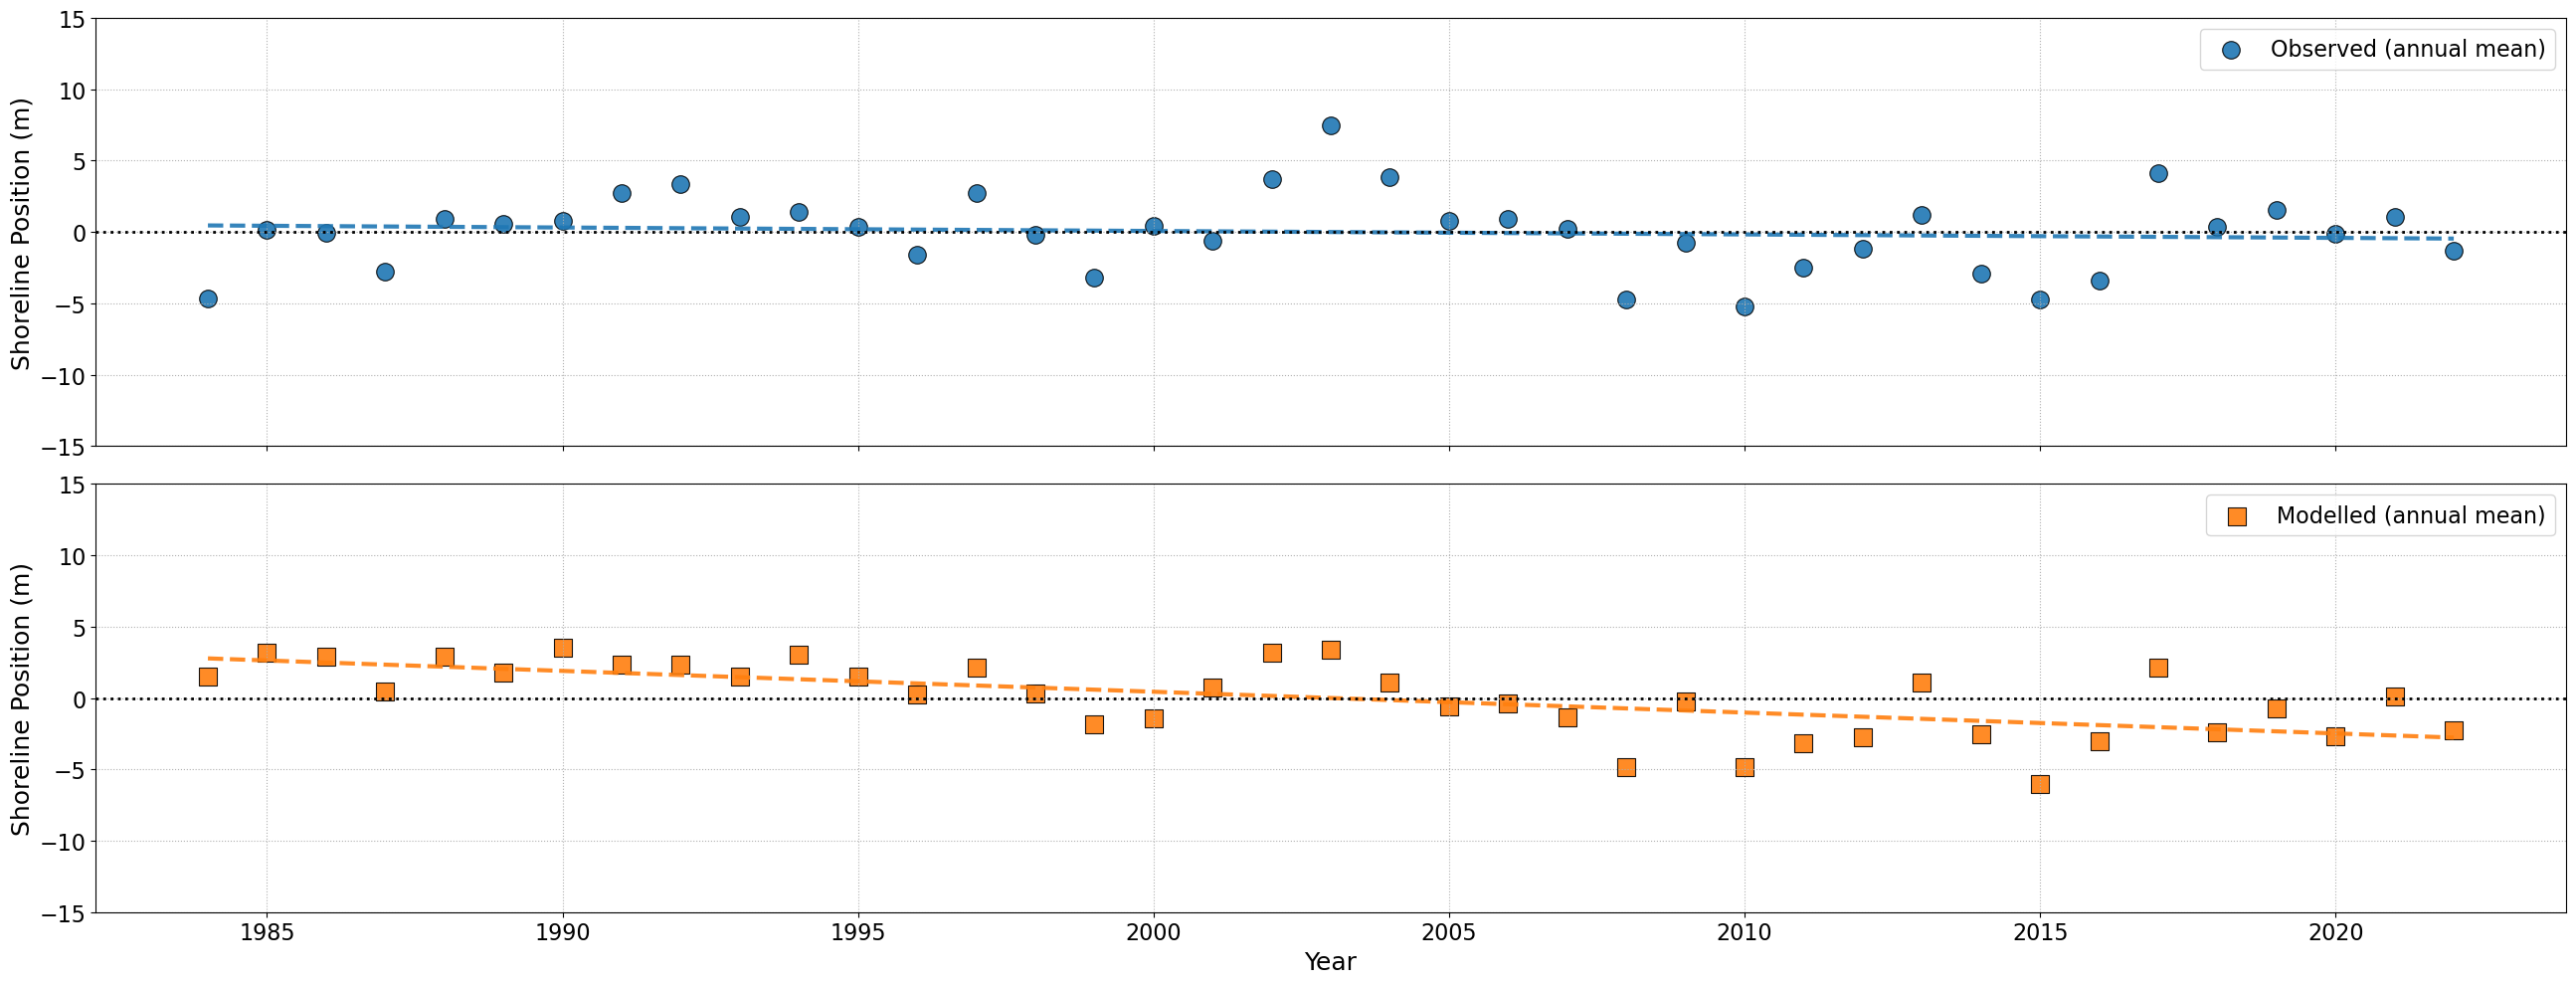

In [13]:
# Annual means from sample 
annual = sampled.copy()
annual["Year"] = annual["date"].dt.year

obs_avg = (
    annual.groupby("Year")["y_detr"]
    .mean()
    .reset_index()
    .rename(columns={"y_detr": "Distance"})
)

mod_avg = (
    annual.groupby("Year")["y_model"]
    .mean()
    .reset_index()
    .rename(columns={"y_model": "Distance"})
)


obs_avg["Distance_zero"] = obs_avg["Distance"] - obs_avg["Distance"].mean()
mod_avg["Distance_zero"] = mod_avg["Distance"] - mod_avg["Distance"].mean()

# Linear trend 
def fit_trend(df, col="Distance_zero"):
    years = df["Year"].values
    vals  = df[col].values

    if len(years) > 1:
        p = np.polyfit(years, vals, 1)
        slope = p[0]
        years_fit = np.linspace(years.min(), years.max(), 100)
        trend = np.polyval(p, years_fit)
    else:
        slope = np.nan
        years_fit = None
        trend = None
    return years_fit, trend, slope

obs_years_fit, obs_trend, obs_slope = fit_trend(obs_avg)
mod_years_fit, mod_trend, mod_slope = fit_trend(mod_avg)


all_vals = np.concatenate([obs_avg["Distance_zero"].values,
                           mod_avg["Distance_zero"].values])
ymax = np.nanmax(np.abs(all_vals))
y_lim = (-ymax * 1.1, ymax * 1.1)  

# 5) Plot
dark_blue = "#1f77b4"
bright_orange = "#ff7f0e"

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(26, 10), sharex=True)

def plot_shoreline(ax, df_avg, years_fit, trend, label, color, marker):
    
    ax.scatter(
        df_avg["Year"], df_avg["Distance_zero"],
        color=color, marker=marker, s=160,
        alpha=0.9, edgecolor="k", linewidth=0.8,
        label=label,
    )

    
    if years_fit is not None and trend is not None:
        ax.plot(
            years_fit, trend,
            linestyle="--", linewidth=3.0, color=color, alpha=0.9
        )

    
    ax.axhline(0, color="black", linestyle=":", linewidth=2.0)

    ax.set_ylabel("Shoreline Position (m)", fontsize=18)
    ax.set_ylim(-15, 15)
    ax.grid(True, linestyle=":", linewidth=0.8)
    ax.legend(loc="upper right", fontsize=16)
    ax.tick_params(axis="both", labelsize=16)


plot_shoreline(
    axes[0],
    obs_avg, obs_years_fit, obs_trend,
    label="Observed (annual mean)",
    color=dark_blue, marker="o",
)


plot_shoreline(
    axes[1],
    mod_avg, mod_years_fit, mod_trend,
    label="Modelled (annual mean)",
    color=bright_orange, marker="s",
)

axes[1].set_xlabel("Year", fontsize=18)
axes[1].tick_params(axis="both", labelsize=16)

plt.tight_layout()
plt.show()


## 6. Computing skill metrics

In [14]:

res_zero = y_mod_zero - y_obs_zero

# MSE and RMSE 
mse_zero = np.mean(res_zero**2)
rmse_zero = np.sqrt(mse_zero)

# NMSE 
nmse_zero = np.sum(res_zero**2) / np.sum(y_obs_zero**2)


# Correlation and R² 
if np.std(y_obs_zero) > 0 and np.std(y_mod_zero) > 0:
    R_zero = np.corrcoef(y_obs_zero, y_mod_zero)[0, 1]
    R2_zero = R_zero**2
else:
    R_zero = np.nan
    R2_zero = np.nan

# Brier Skill Score 
BSS_zero = 1.0 - nmse_zero

print("Skill metrics for demeaned series (survey times):")
print(f" NMSE (demeaned)     : {nmse_zero:.3f}")
print(f" RMSE (demeaned, m)  : {rmse_zero:.3f}")
print(f" Correlation R       : {R_zero:.3f}")
print(f" R²                  : {R2_zero:.3f}")
print(f" BSS (demeaned)      : {BSS_zero:.3f}")

Skill metrics for demeaned series (survey times):
 NMSE (demeaned)     : 0.436
 RMSE (demeaned, m)  : 3.434
 Correlation R       : 0.768
 R²                  : 0.590
 BSS (demeaned)      : 0.564


## 7. Directional Categorical Skill

In [15]:
delta_obs = np.diff(y_obs)
delta_mod = np.diff(y_mod)

# Threshold: 5% of total observed range 
y_range   = y_obs.max() - y_obs.min()
threshold = 0.05 * y_range

def categorize(delta, thr):
    """Return 'accretion', 'erosion', or 'stable' based on delta and threshold thr."""
    if delta > thr:
        return "accretion"
    elif delta < -thr:
        return "erosion"
    else:
        return "stable"

cats_obs = np.array([categorize(d, threshold) for d in delta_obs])
cats_mod = np.array([categorize(d, threshold) for d in delta_mod])

categories = ["erosion", "accretion", "stable"]
skill_by_cat = {}

for cat in categories:
    mask = (cats_obs == cat)
    n_events = mask.sum()
    if n_events > 0:
        n_correct = np.sum(cats_mod[mask] == cat)
        skill_by_cat[cat] = {
            "n_events": int(n_events),
            "n_correct": int(n_correct),
            "accuracy": n_correct / n_events,
        }
    else:
        skill_by_cat[cat] = {
            "n_events": 0,
            "n_correct": 0,
            "accuracy": np.nan,
        }

overall_accuracy = np.mean(cats_obs == cats_mod)

print("Directional (categorical) skill")
for cat in categories:
    s = skill_by_cat[cat]
    if s["n_events"] > 0:
        print(
            f" {cat.capitalize():9s}: "
            f"events = {s['n_events']:3d}, "
            f"correct = {s['n_correct']:3d}, "
            f"accuracy = {s['accuracy']:.2f}"
        )
    else:
        print(f" {cat.capitalize():9s}: no events")

print(f"\nOverall directional accuracy: {overall_accuracy:.2f}")

Directional (categorical) skill
 Erosion  : events = 208, correct = 103, accuracy = 0.50
 Accretion: events = 228, correct = 108, accuracy = 0.47
 Stable   : events = 294, correct = 222, accuracy = 0.76

Overall directional accuracy: 0.59
